! <img src="FBS-with-Trendlines.png">

### The trendlines are polynomials of degree 1, 2, 3. Which trendline is the best predictor?

In [51]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF, Series as Ser
from matplotlib import pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


In [52]:
path = "/Users/jonathan/Desktop/weight-plus-glucose/all-day-glucose/all-day-glucose.xlsx"
df0 = pd.read_excel(path).iloc[:, :18]
columns = df0.iloc[0, 0:18]
df0.columns = columns
pd.set_option('display.max_rows', 4)
df0

,Date,FBS,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,Average by Date
0,Date,FBS,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM,8 PM,9 PM,10 PM,Average by Date
1,2023-11-08,NaN,NaN,138,NaN,NaN,NaN,109,NaN,NaN,NaN,127,NaN,NaN,NaN,124,NaN,124.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2024-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,2024-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# The original spreadsheet contains rows at the end containing only the date 
# (so that the ranges of its charts don't have to be updated every day.) We 
# trim these extra rows by using the FBS column to define the length of the 
# dataframe.

def check_FBS_values(df): 
    fbsvals = df["FBS"].values
    for i in range(len(df)):
        if type(fbsvals[i]) != int or fbsvals[i] <= 0:
            raise ValueError("Invalid FBS \"" + str(fbsvals[i]) + \
                "\" at row " + str(i))
df = df0.iloc[1:, 0:2].dropna() # get rid of headers and nans
df.index = range(len(df))

# Introduce a column showing das from day 0
df = pd.concat([Ser(range(len(df))), df], axis=1)
df.columns = ["Day", "Date", "FBS"]

check_FBS_values(df)

pd.set_option('display.max_rows', 4)
df

,Day,Date,FBS
0,0,2023-11-09,104
1,1,2023-11-10,108
...,...,...,...
108,108,2024-03-23,116
109,109,2024-03-24,115


In [54]:
X = np.array(df["Day"])
y = np.array(df["FBS"])
#for z in list(zip(X, y)): print(z)

Double-click to show the following code's URL:
<a href="https://scikit-learn.org/stable/modules/linear_model#polynomial-regression-extending-linear-models-with-basis-functions.html"></a>

In [55]:
# Code source: Jaques Grobler
# License: BSD 3 clause

def groblers_regression():
    '''Encapsulate his code as a function: calling it may contaminate other variables'''
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn import datasets, linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    
    # Load the diabetes dataset
    X, y = datasets.load_diabetes(return_X_y=True)
    
    # Use only one feature
    X = X[:, np.newaxis, 2]
    
    # Split the data into training/testing sets
    X_train = X[:-20]
    X_test = X[-20:]
    
    # Split the targets into training/testing sets
    y_train = y[:-20]
    y_test = y[-20:]
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Train the model using the training sets
    regr.fit(X_train, y_train)
    
    # Make predictions using the testing set
    y_pred_lin = regr.predict(X_test)
    print("y_pred_lin length:", len(y_pred_lin))
    
    # The coefficients
    print("Coefficients: \n", regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
    
    # Plot outputs
    plt.scatter(X_test, y_test, color="black")
    plt.plot(X_test, y_pred_lin, color="blue", linewidth=3)
    plt.show()

#groblers_regression()

In [56]:
# Here's my paraphrase of M. Grobler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def sort_X_and_y(X_, y_):
    i_sorted = np.argsort(X_)

    X_sorted = np.sort(X_)
    y_sorted = np.array([y_[i] for i in i_sorted])
    return X_sorted, y_sorted

print("Latest FBS:", y[-1])

# Create linear regression model
regr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42) # identical to the polynomial version

X_train_sorted, y_train_sorted = sort_X_and_y(X_train, y_train)
X_test_sorted, y_test_sorted = sort_X_and_y(X_test, y_test)

# Train the linear model using the training sets
regr.fit(X_train_sorted.reshape(-1, 1), y_train_sorted.reshape(-1, 1))

# Make predictions for linear regression using the testing set
y_pred_lin_sorted = regr.predict(X_test_sorted.reshape(-1, 1))

# Coefficients for mean squared error. linear regression:
mse_lin = [1, mean_squared_error(y_test_sorted, y_pred_lin_sorted)]

Latest FBS: 115


<Figure size 1000x1000 with 0 Axes>

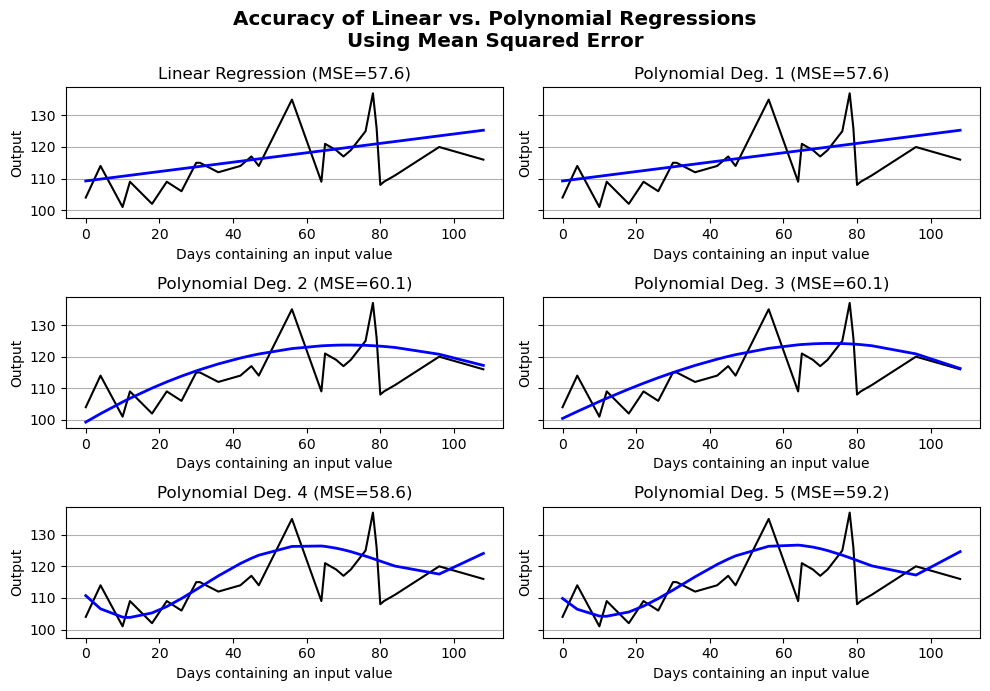

In [57]:
# Now fit to n-degree polynomials
degrees = [1, 2, 3, 4, 5] #list(range(2, 11)) + [15]
mse = []

plt.figure(figsize=(10, 10), layout='constrained') #

# Plot outputs:
# Set shape of plots
ncols = 2
nrows = (len(degrees)+1) // ncols + (len(degrees)+1) % 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7), 
    sharey=True, tight_layout=True)

# Set suptitle
fig.suptitle("Accuracy of Linear vs. Polynomial Regressions\n" + \
             "Using Mean Squared Error", 
             size="x-large", weight="bold", wrap=True)
         
# Set x- and y-axis data common to linear and polynomial plots
xlabel = "Days containing an input value"
ylabel = "Output"
y_axis_grid = 'y'
y_ticks = np.arange(100, 145, 10)

# Plot linear regression
axes[0][0].plot(X_test_sorted, y_test_sorted, color="black")
axes[0][0].plot(X_test_sorted, y_pred_lin_sorted, color="blue", linewidth=2)
axes[0][0].set_title(f"Linear Regression (MSE={mse_lin[1]:2.1f})")
axes[0][0].set_xlabel(xlabel)
axes[0][0].set_ylabel(ylabel)
axes[0][0].set_yticks(y_ticks)
axes[0][0].grid(axis = y_axis_grid)

# Plot polynomial regressions
for dg in degrees:
    model_poly = Pipeline([('poly', PolynomialFeatures(degree=dg)),
    ('linear', LinearRegression())]) # fit_intercept=False
    model_poly.fit(X_train_sorted.reshape(-1, 1), y_train_sorted.reshape(-1, 1))
#         regr.fit(X_train_sorted.reshape(-1, 1), y_train_sorted.reshape(-1, 1))
    
    # Make predictions for polynomial regression using the testing set
    y_pred_poly_sorted = model_poly.predict(X_test_sorted.reshape(-1, 1))

    # Coefficients for mean squared error, polynomial regression:
    mse_poly = ([degrees, mean_squared_error(y_test_sorted, y_pred_poly_sorted)])
    
    ax_x, ax_y = (dg+2)%2, (dg+2)//2 - 1
    axes[ax_y][ax_x].plot(X_test_sorted, y_test_sorted, color="black")
    axes[ax_y][ax_x].plot(X_test_sorted, y_pred_poly_sorted, color="blue", linewidth=2)
    axes[ax_y][ax_x].set_title ("Polynomial Deg. " + str(dg) + f" (MSE={mse_poly[1]:2.1f})")
    axes[ax_y][ax_x].set_xlabel(xlabel)
    axes[ax_y][ax_x].set_ylabel(ylabel)
    axes[ax_y][ax_x].grid(axis = y_axis_grid)

    
plt.show()